In [5]:
import numpy
from scipy.stats import wishart
from skimage import transform as tf
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cbook
import warnings
import itertools
from scipy.stats import multivariate_normal
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
%matplotlib inline

In [27]:
def generate_clusters(nb_samples=1, nb_obs=1000, alpha = .01, prior_mean_scale=10, prior_covariance_scale=np.eye(2)/.2):
    '''
    Generation function for the clustering problem

    Args:
        nb_samples(int): number of samples
        nb_obs(int): for each sample, the number of observations
        alpha (float): the parameter which regulates the creation of new samples.
            the greater alpha, the more clusters will be created
        prior_mean_scale (float) : hyper-parameter for the prior of the means of the gaussian distribution.
            the greater prior_mean_scale will the more the means of the gaussian distributions will be 
            spread out
        prior_covariance_scale (matrix) : hyper-parameter for the prior of the covariance matrix
            of the gaussian distributions

    Return:
        X - a tensor of size (nb_sample, nb_obs, 2). For each sample, X gives the 2d coordinates of each observation
        Z - a tensor of size (nb_sample, nb_obs, 2). For each sample, Z gives the cluster of each observation
        nb_current_clusters - a tensor of size (nb_sample, n_obs). For each sample, K gives the number of clusters 
            as a function of the number of past observations available
    '''
    # initialize output variables
    X                   = np.zeros([nb_samples, nb_obs, 2])
    Z                   = np.zeros([nb_samples, nb_obs])
    nb_current_clusters = np.ones([nb_samples, nb_obs], dtype=np.int)
    # initialize dictionaries for means and covariances of each cluster
    dict_of_means       = {}
    dict_of_covariances = {}
    # sample mean and covariance for the first observation of each sample and assign cluster 0 to that observation
    for k in range(nb_samples):
        new_mean       = np.random.normal(size=2, scale=prior_mean_scale)
        new_covariance = wishart.rvs(2, prior_covariance_scale)
        X[k, 0] = np.random.multivariate_normal(new_mean, new_covariance)
        Z[k, 0] = 0
        dict_of_means[k, nb_current_clusters[k, 0] - 1] = new_mean
        dict_of_covariances[k, nb_current_clusters[k, 0] - 1] = new_covariance
    # iterate over all over observations    
    for it_nb_obs in range(1, nb_obs):
        # probability to start a new cluster
        proba_new_cluster = alpha/(alpha + nb_current_clusters[:,it_nb_obs])
        new_cluster       = (np.random.rand(nb_samples) < proba_new_cluster)
        # for each observation, iterate over samples
        for k in range(nb_samples):
            if new_cluster[k]:
                # increment number of clusters
                nb_current_clusters[k, it_nb_obs:] += 1 
                # sample mean and covariance for new cluster
                new_mean                = np.random.normal(size=2, scale=prior_mean_scale)
                new_covariance          = wishart.rvs(2, prior_covariance_scale) 
                # sample new observation and assign new cluster
                X[k, it_nb_obs] = np.random.multivariate_normal(new_mean, new_covariance)
                Z[k, it_nb_obs] = nb_current_clusters[k, it_nb_obs] - 1
                # save new cluster
                dict_of_means[k, nb_current_clusters[k, it_nb_obs] - 1]       = new_mean
                dict_of_covariances[k, nb_current_clusters[k, it_nb_obs] - 1] = new_covariance
            else:
                # compute the probability of choosing each existing cluster
                counts = np.array([(Z[k, :it_nb_obs] == j).sum() for j in range(int(Z[k, :it_nb_obs].max() + 1))])
                probability_oldcluster = (sum(counts)/counts)/sum(sum(counts)/counts)
                # sample cluster from existing ones
                old_cluster_id = np.random.choice(len(probability_oldcluster), p=probability_oldcluster)
                # sample observation and assign cluster
                X[k, it_nb_obs] = np.random.multivariate_normal(dict_of_means[k, old_cluster_id],
                                                        dict_of_covariances[k, old_cluster_id]) 
                Z[k, it_nb_obs] = old_cluster_id
    return X, Z, nb_current_clusters

the final number of clusters is 7


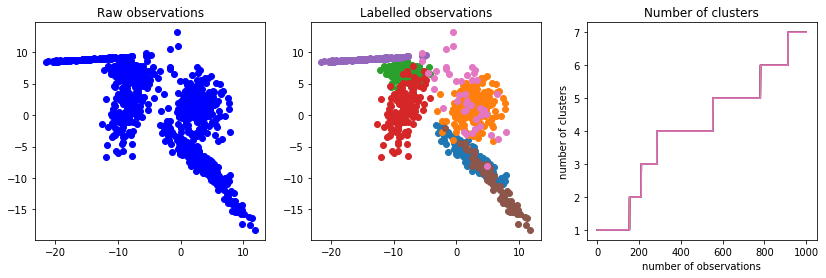

In [37]:
# generate the clusters and select first (and only) sample
X, Z, K = generate_clusters()
i = 0

# how many clusters ?
print('the final number of clusters is {}'.format(K[i, -1]))

# plot the clusters
plt.figure(figsize=(14,4))
for idx_k in range(K[i, -1]):
    plt.subplot(1,3,1)
    plt.plot(X[i, Z[i] == idx_k,0], X[i,Z[i] == idx_k,1], 'o', color='blue')
    plt.title('Raw observations')    
    plt.subplot(1,3,2)
    plt.plot(X[i,Z[i] == idx_k,0], X[i,Z[i] == idx_k,1], 'o')
    plt.title('Labelled observations')
    plt.subplot(1,3,3)
    plt.plot(K[i])
    plt.xlabel('number of observations')
    plt.ylabel('number of clusters')
    plt.title('Number of clusters')    